In [84]:
%matplotlib inline

# standard library
import os
import time
from pathlib import Path

# data munging
import pandas as pd
import numpy as np

# model building
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

np.random.seed(42)
tf.random.set_seed(42)

plt.style.use(style="seaborn")
plt.rcParams['figure.dpi'] = 400
sns.set_style('whitegrid')



In [85]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [86]:
!nvidia-smi

Thu Jul 14 04:59:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P8    18W / 200W |   2813MiB /  4096MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [87]:
################################################

ticker_list = ["aapl", "amzn", "msft"]

ticker = ticker_list[1]

ticker_upper = ticker.upper()

print("Ticker:", ticker_upper)

################################################

source_list = ["BENZINGA", "TWINT"]

source = source_list[0]

print("Source:", source)

################################################

model_type_list = ["univariate", "multivariate", "multivariate_with_news_sentiment", "multivariate_with_tweet_sentiment"]

model_type = model_type_list[2]

print("Model Type:", model_type.upper())

################################################

include_logged_returns = False

print("Include Logged Returns:", include_logged_returns)

################################################

training_length_list = ["low", "high"]

training_length = training_length_list[1]

if training_length == "low":
    MAX_EPOCHS = 100
    patience=30
elif training_length == "high":
    MAX_EPOCHS = 500
    patience=50

print("Max Epochs:", MAX_EPOCHS)
print("Patience:", patience)

################################################

Ticker: AMZN
Source: BENZINGA
Model Type: MULTIVARIATE_WITH_NEWS_SENTIMENT
Include Logged Returns: False
Max Epochs: 500
Patience: 50


In [88]:
csv_path = f"/app/StockPricePredictions/data/alphavantage/time_series_daily_adjusted/{ticker_upper}/{ticker_upper}_WITH_{source}_FINBERT_SA.csv"

In [89]:
df = pd.read_csv(csv_path)
df.sort_values(by=["date"], ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

date_time = pd.to_datetime(df.pop('date'))

df.index = date_time

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3064 entries, 2010-01-04 to 2022-03-04
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   1. open               3064 non-null   float64
 1   2. high               3064 non-null   float64
 2   3. low                3064 non-null   float64
 3   4. close              3064 non-null   float64
 4   5. adjusted close     3064 non-null   float64
 5   6. volume             3064 non-null   float64
 6   7. dividend amount    3064 non-null   float64
 7   8. split coefficient  3064 non-null   float64
 8   date_time             3064 non-null   object 
 9   day_of_week           3064 non-null   int64  
 10  return                3064 non-null   float64
 11  increase              3064 non-null   float64
 12  log_return            3064 non-null   float64
 13  negative              3064 non-null   float64
 14  nuetral               3064 non-null   float64
 15  pos

In [91]:
df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,date_time,day_of_week,return,increase,log_return,negative,nuetral,positive
date,,,,,,,,,,,,,,,,
2010-01-04,136.25,136.610,133.14,133.90,133.90,7599900.0,0.0,1.0,2010-01-04,0,0.000000,0.0,0.000000,0.0,0.0,0.0
2010-01-05,133.43,135.479,131.81,134.69,134.69,8851900.0,0.0,1.0,2010-01-05,1,0.005900,1.0,0.005883,0.0,0.0,0.0
2010-01-06,134.60,134.730,131.65,132.25,132.25,7178800.0,0.0,1.0,2010-01-06,2,-0.018116,0.0,-0.018282,0.0,0.0,0.0
2010-01-07,132.01,132.320,128.80,130.00,130.00,11030200.0,0.0,1.0,2010-01-07,3,-0.017013,0.0,-0.017160,0.0,0.0,0.0
2010-01-08,130.56,133.680,129.03,133.52,133.52,9830500.0,0.0,1.0,2010-01-08,4,0.027077,1.0,0.026717,0.0,0.0,0.0


In [92]:
df.tail()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,date_time,day_of_week,return,increase,log_return,negative,nuetral,positive
date,,,,,,,,,,,,,,,,
2022-02-28,3048.50,3089.00,3017.00,3071.26,3071.26,2884171.0,0.0,1.0,2022-02-28,0,-0.001466,0.0,-0.001467,0.434618,0.451638,0.113744
2022-03-01,3054.65,3081.98,2999.54,3022.84,3022.84,2243679.0,0.0,1.0,2022-03-01,1,-0.015766,0.0,-0.015891,0.600509,0.265521,0.133970
2022-03-02,3016.98,3059.99,2975.00,3041.05,3041.05,2366736.0,0.0,1.0,2022-03-02,2,0.006024,1.0,0.006006,0.368508,0.540080,0.091412
2022-03-03,3070.63,3078.58,2937.12,2957.97,2957.97,3259860.0,0.0,1.0,2022-03-03,3,-0.027320,0.0,-0.027700,0.133283,0.630151,0.236567
2022-03-04,2943.18,2957.00,2876.14,2912.82,2912.82,3049156.0,0.0,1.0,2022-03-04,4,-0.015264,0.0,-0.015382,0.511864,0.461260,0.026875


In [93]:
# df["log_return"] = df["log_return"].shift(1)

In [94]:
df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,date_time,day_of_week,return,increase,log_return,negative,nuetral,positive
date,,,,,,,,,,,,,,,,
2010-01-04,136.25,136.610,133.14,133.90,133.90,7599900.0,0.0,1.0,2010-01-04,0,0.000000,0.0,0.000000,0.0,0.0,0.0
2010-01-05,133.43,135.479,131.81,134.69,134.69,8851900.0,0.0,1.0,2010-01-05,1,0.005900,1.0,0.005883,0.0,0.0,0.0
2010-01-06,134.60,134.730,131.65,132.25,132.25,7178800.0,0.0,1.0,2010-01-06,2,-0.018116,0.0,-0.018282,0.0,0.0,0.0
2010-01-07,132.01,132.320,128.80,130.00,130.00,11030200.0,0.0,1.0,2010-01-07,3,-0.017013,0.0,-0.017160,0.0,0.0,0.0
2010-01-08,130.56,133.680,129.03,133.52,133.52,9830500.0,0.0,1.0,2010-01-08,4,0.027077,1.0,0.026717,0.0,0.0,0.0


In [95]:
df.tail()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,date_time,day_of_week,return,increase,log_return,negative,nuetral,positive
date,,,,,,,,,,,,,,,,
2022-02-28,3048.50,3089.00,3017.00,3071.26,3071.26,2884171.0,0.0,1.0,2022-02-28,0,-0.001466,0.0,-0.001467,0.434618,0.451638,0.113744
2022-03-01,3054.65,3081.98,2999.54,3022.84,3022.84,2243679.0,0.0,1.0,2022-03-01,1,-0.015766,0.0,-0.015891,0.600509,0.265521,0.133970
2022-03-02,3016.98,3059.99,2975.00,3041.05,3041.05,2366736.0,0.0,1.0,2022-03-02,2,0.006024,1.0,0.006006,0.368508,0.540080,0.091412
2022-03-03,3070.63,3078.58,2937.12,2957.97,2957.97,3259860.0,0.0,1.0,2022-03-03,3,-0.027320,0.0,-0.027700,0.133283,0.630151,0.236567
2022-03-04,2943.18,2957.00,2876.14,2912.82,2912.82,3049156.0,0.0,1.0,2022-03-04,4,-0.015264,0.0,-0.015382,0.511864,0.461260,0.026875


In [96]:
df.fillna(0.0, inplace=True)

In [97]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
1. open,3064.0,1.095358e+03,1.062551e+03,105.925000,2.587150e+02,6.171450e+02,1.770055e+03,3.744000e+03
2. high,3064.0,1.106956e+03,1.074210e+03,111.290000,2.614875e+02,6.251850e+02,1.786257e+03,3.773078e+03
3. low,3064.0,1.082360e+03,1.049357e+03,105.800000,2.565850e+02,6.057650e+02,1.749290e+03,3.696793e+03
4. close,3064.0,1.094912e+03,1.061586e+03,108.610000,2.590100e+02,6.169900e+02,1.768955e+03,3.731410e+03
5. adjusted close,3064.0,1.094912e+03,1.061586e+03,108.610000,2.590100e+02,6.169900e+02,1.768955e+03,3.731410e+03
6. volume,3064.0,4.453434e+06,2.702337e+06,881337.000000,2.807655e+06,3.760600e+06,5.240026e+06,4.242110e+07
7. dividend amount,3064.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
8. split coefficient,3064.0,1.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
day_of_week,3064.0,2.022846e+00,1.399408e+00,0.000000,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00
return,3064.0,1.201895e-03,1.986214e-02,-0.126568,-8.492083e-03,1.009674e-03,1.130947e-02,1.574570e-01


Text(0.5, 0, 'Date')

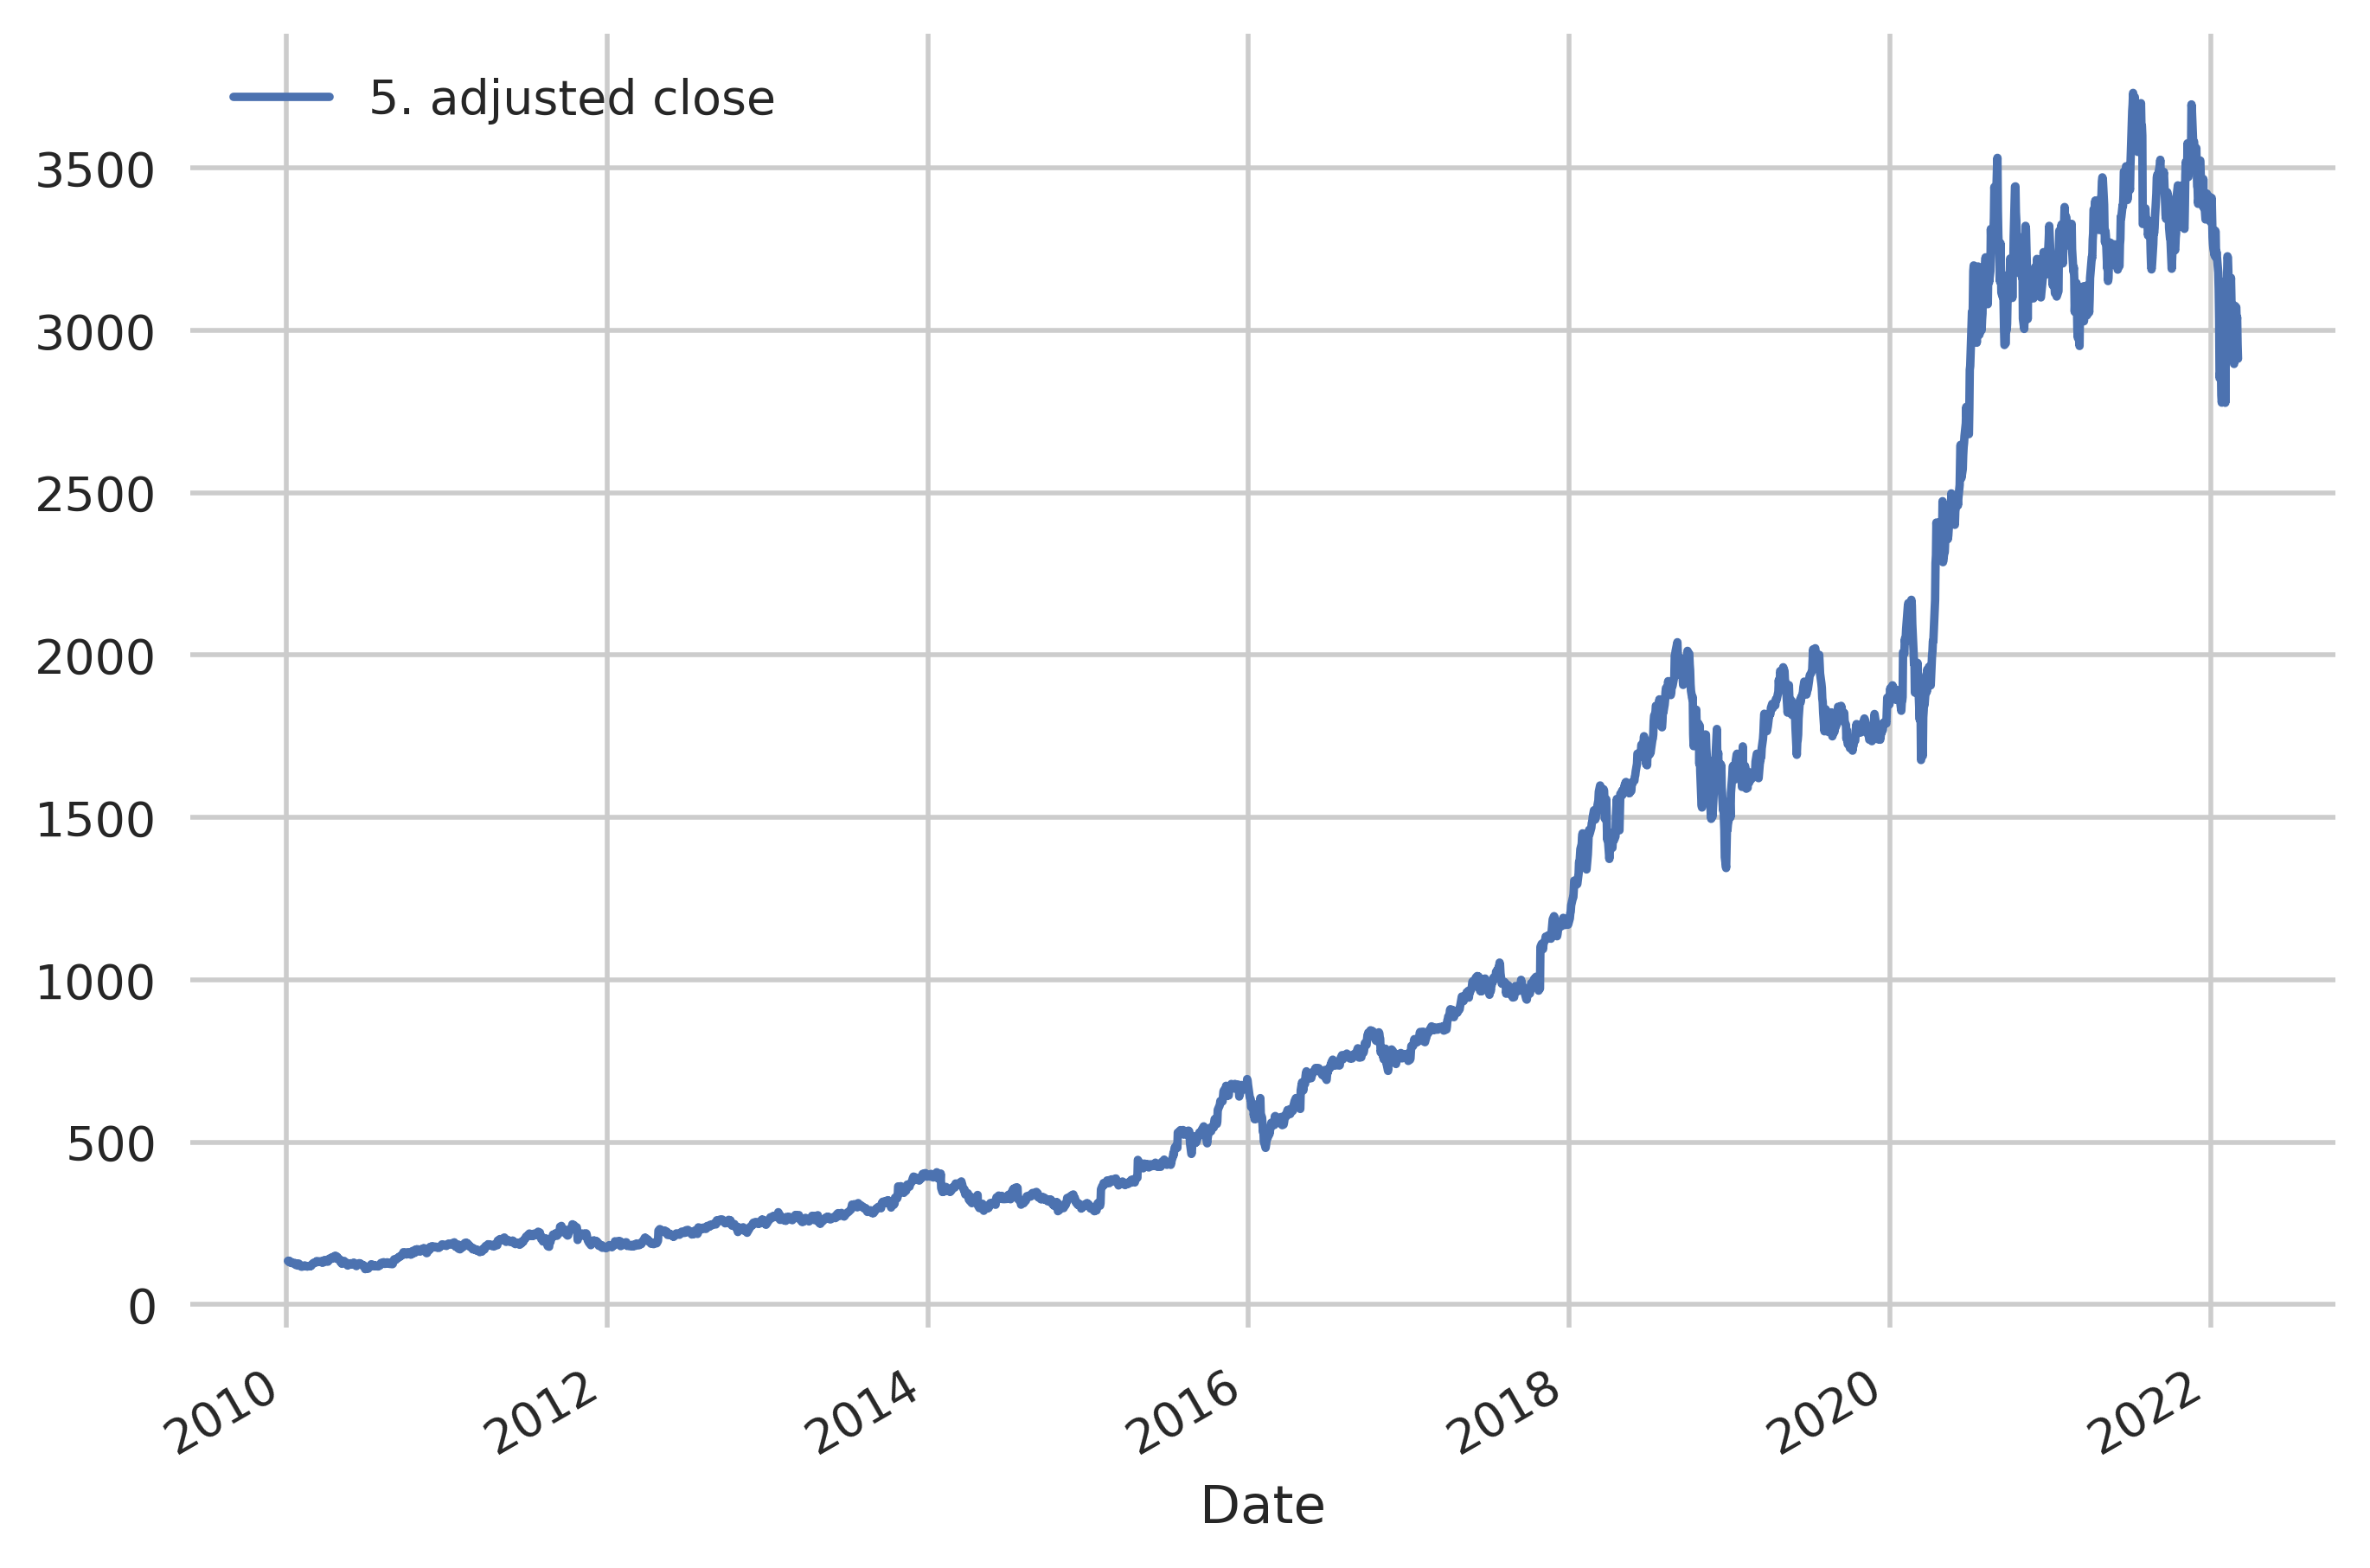

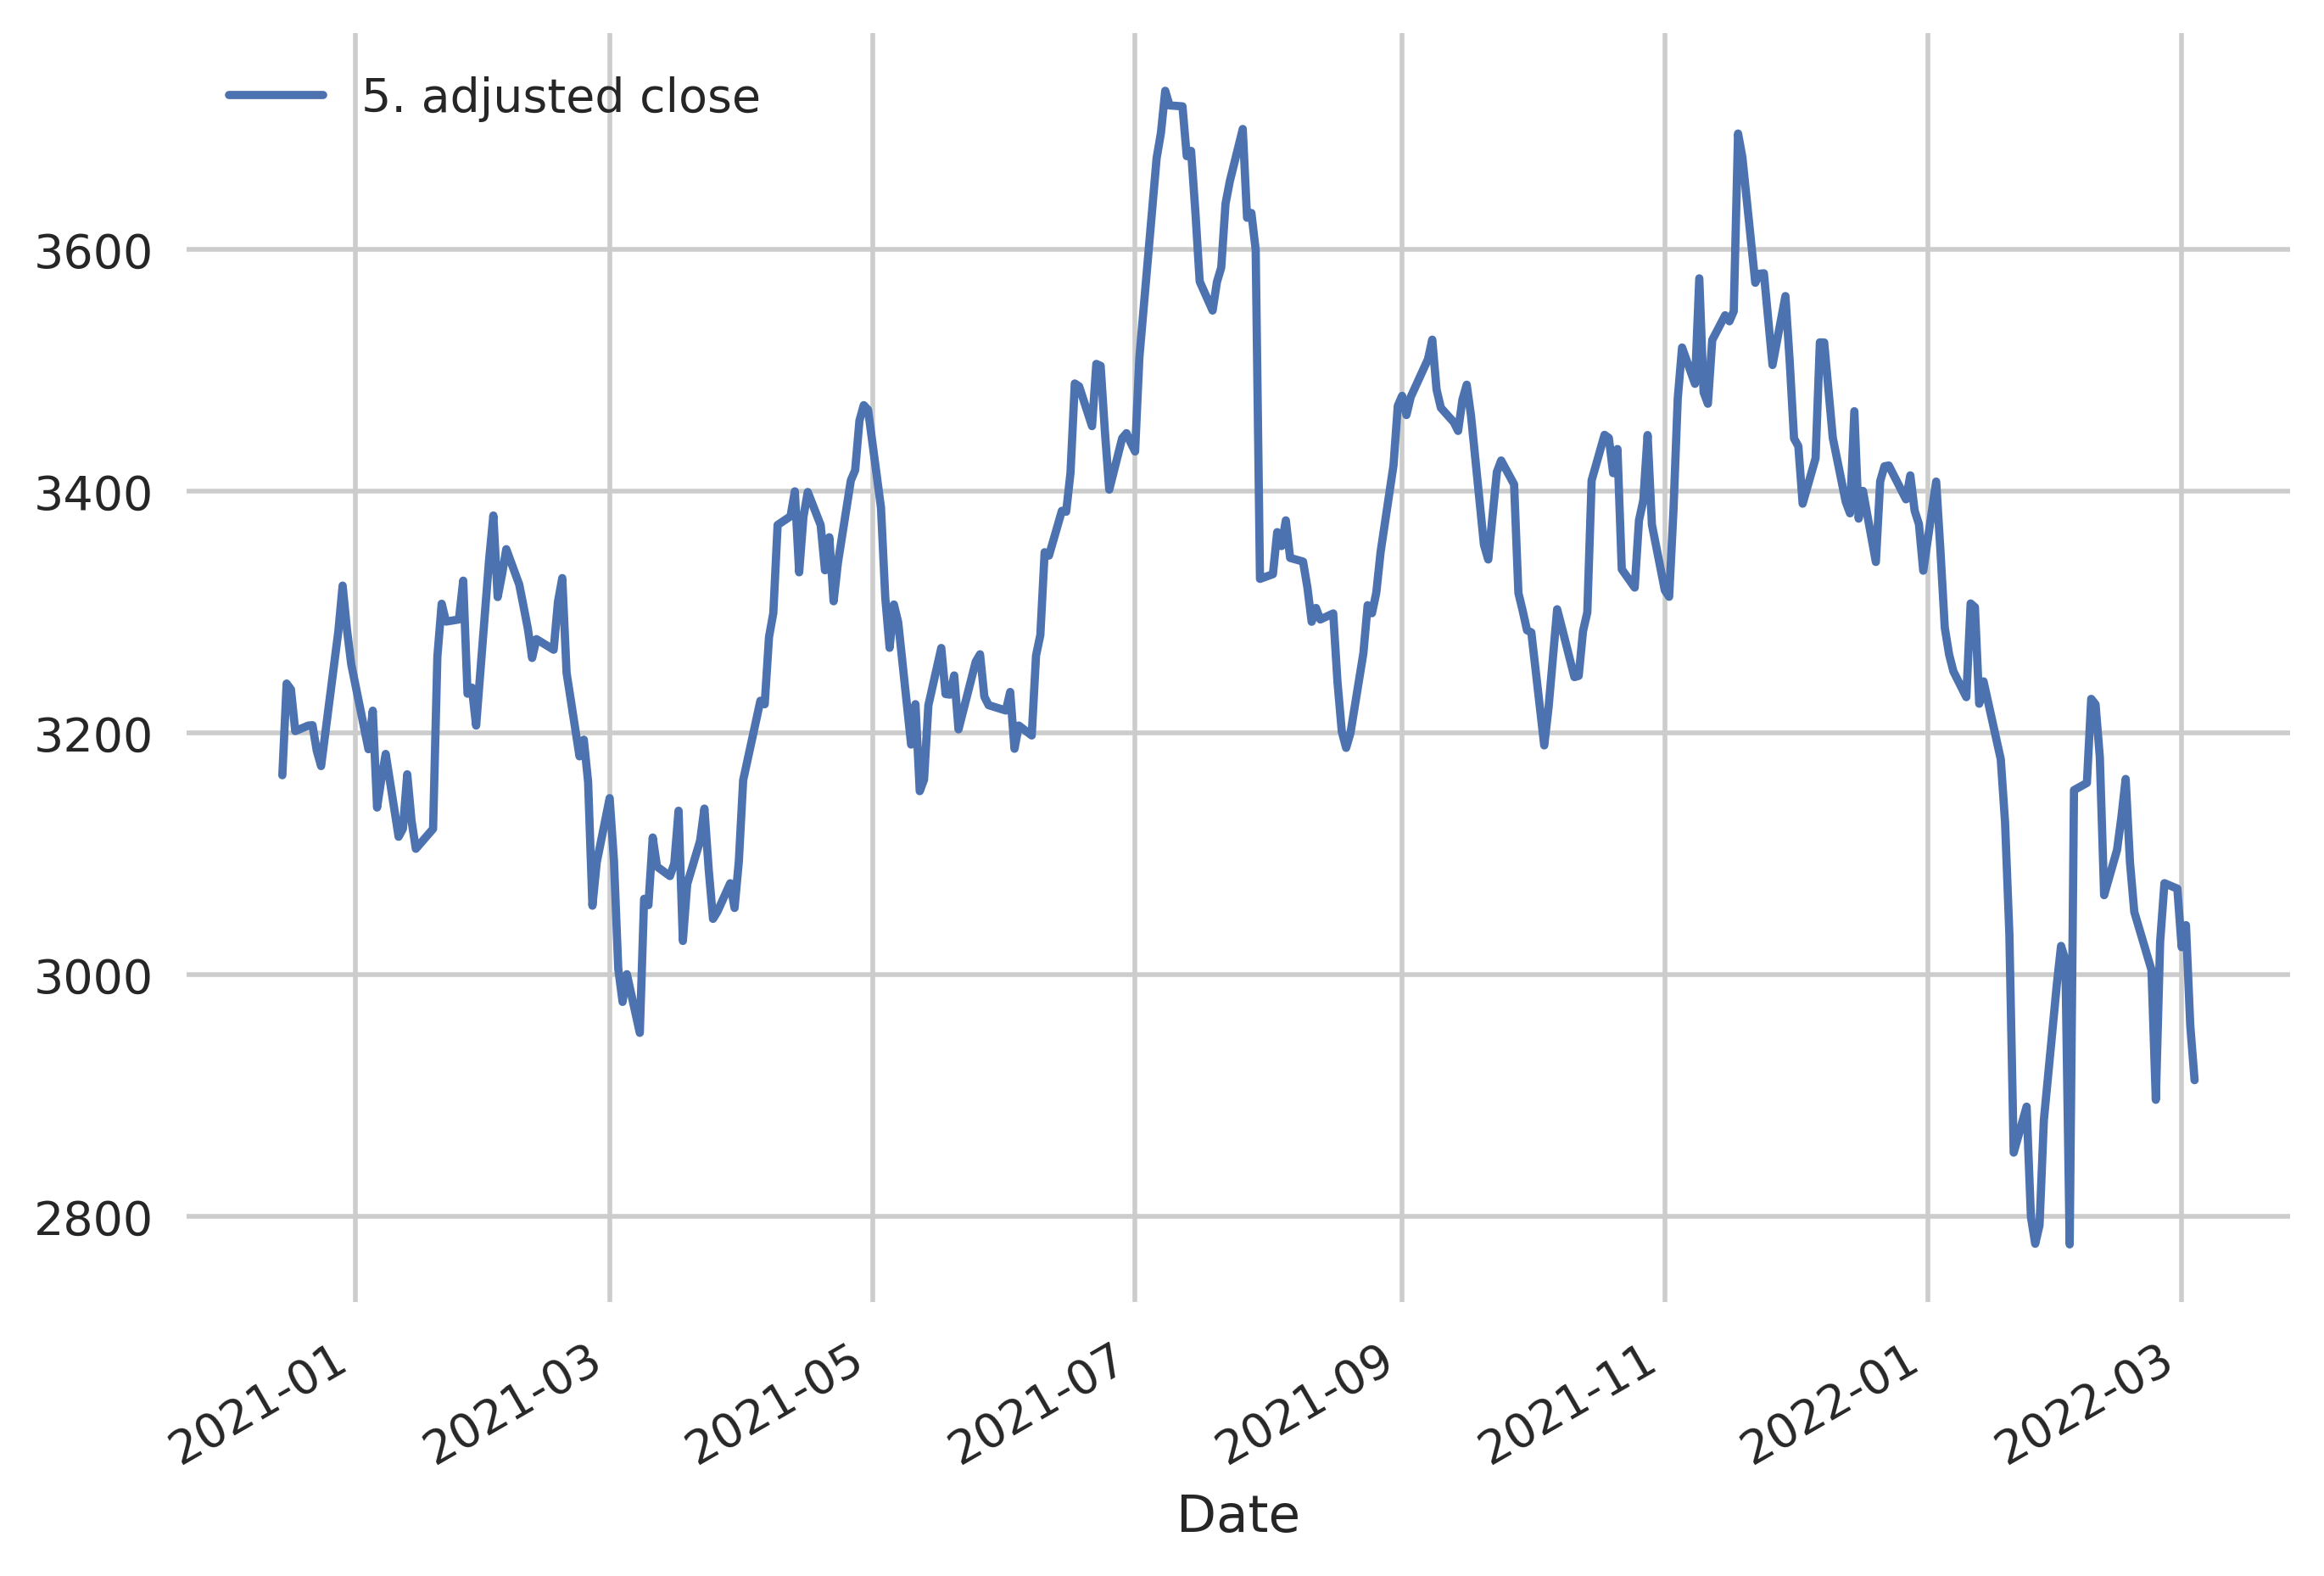

In [98]:
plot_cols = ['5. adjusted close']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)
plt.xlabel('Date')

plot_features = df[plot_cols][2757:]
plot_features.index = date_time[2757:]
_ = plot_features.plot(subplots=True)
plt.xlabel('Date')

Text(0.5, 1.0, 'Logged Returns')

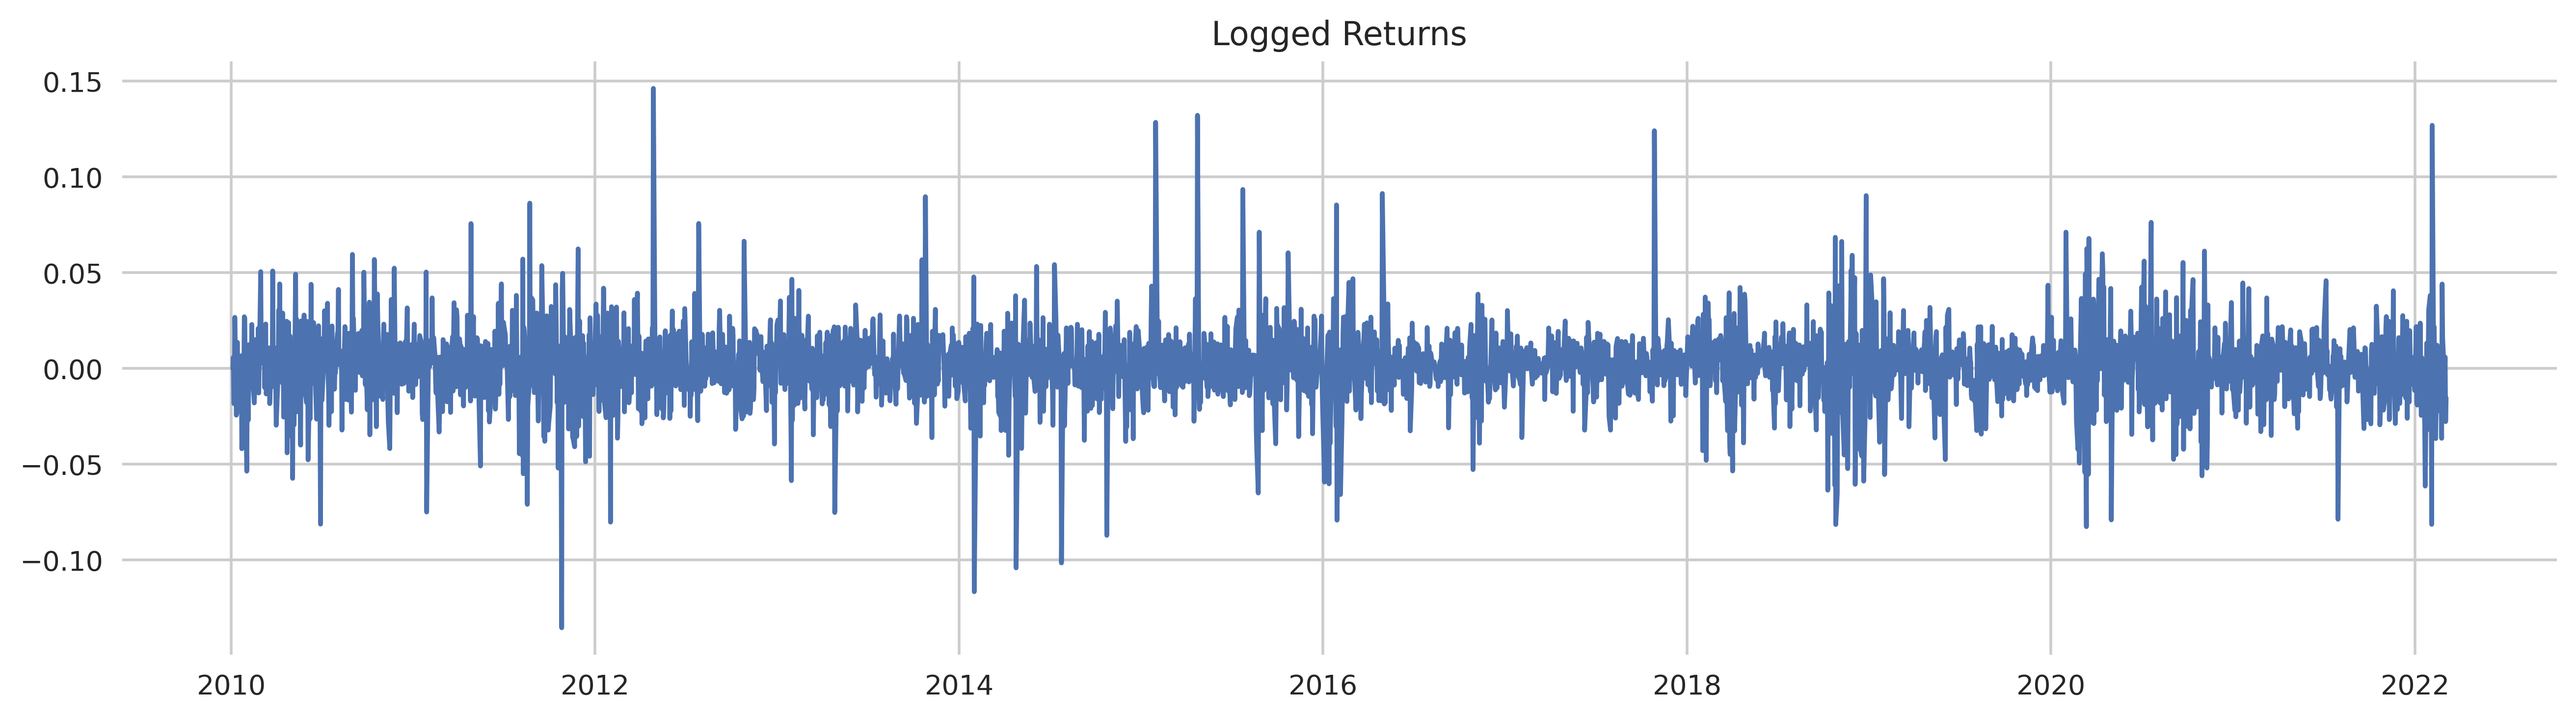

In [99]:
plt.figure(1, figsize=(16, 4))
plt.plot(df.log_return)
plt.title("Logged Returns")

In [100]:
if model_type == "univariate":
    if not include_logged_returns:
        feature_list = ["5. adjusted close"]
    else:
        feature_list = ["5. adjusted close", "log_return"]

elif model_type == "multivariate":
    if not include_logged_returns:
        feature_list = ["5. adjusted close", "2. high", "3. low", "6. volume"]
    else:
        feature_list = ["5. adjusted close", "2. high", "3. low", "6. volume", "log_return"]

elif model_type == "multivariate_with_news_sentiment" or model_type == "multivariate_with_tweet_sentiment":
    if not include_logged_returns:
        feature_list = ["5. adjusted close", "2. high", "3. low", "6. volume", "negative", "nuetral", "positive"]
    else:
        feature_list = ["5. adjusted close", "2. high", "3. low", "6. volume", "negative", "nuetral", "positive", "log_return"]



X = df[feature_list].values


In [101]:
from sklearn.preprocessing import MinMaxScaler

In [102]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = scaler.transform(X)

In [103]:
y = [x[0] for x in X_scaled]

#### Train test split

In [104]:
split = int(len(X_scaled) * 0.9)
print(split)

2757


In [105]:
X_train = X_scaled[:split]
X_test = X_scaled[split : len(X_scaled)]
y_train = y[:split]
y_test = y[split : len(y)]

In [106]:
print(len(X_train))
print(len(X_test))

2757
307


#### Window Size


In [107]:
n = 63
Xtrain = []
ytrain = []
Xtest = []
ytest = []
for i in range(n, len(X_train)):
    Xtrain.append(X_train[i - n : i, : X_train.shape[1]])
    ytrain.append(y_train[i])  # predict next record
for i in range(n, len(X_test)):
    Xtest.append(X_test[i - n : i, : X_test.shape[1]])
    ytest.append(y_test[i])  # predict next record

In [108]:
df.head(5)

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,date_time,day_of_week,return,increase,log_return,negative,nuetral,positive
date,,,,,,,,,,,,,,,,
2010-01-04,136.25,136.610,133.14,133.90,133.90,7599900.0,0.0,1.0,2010-01-04,0,0.000000,0.0,0.000000,0.0,0.0,0.0
2010-01-05,133.43,135.479,131.81,134.69,134.69,8851900.0,0.0,1.0,2010-01-05,1,0.005900,1.0,0.005883,0.0,0.0,0.0
2010-01-06,134.60,134.730,131.65,132.25,132.25,7178800.0,0.0,1.0,2010-01-06,2,-0.018116,0.0,-0.018282,0.0,0.0,0.0
2010-01-07,132.01,132.320,128.80,130.00,130.00,11030200.0,0.0,1.0,2010-01-07,3,-0.017013,0.0,-0.017160,0.0,0.0,0.0
2010-01-08,130.56,133.680,129.03,133.52,133.52,9830500.0,0.0,1.0,2010-01-08,4,0.027077,1.0,0.026717,0.0,0.0,0.0


In [109]:
_ = np.array(ytrain[0])

if len(feature_list) == 1:
    _ = np.c_[_]

elif len(feature_list) == 2:
    _ = np.c_[_, np.zeros(_.shape)]

elif len(feature_list) == 3:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 4:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 5:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 6:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 7:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]    

elif len(feature_list) == 8:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]      

In [110]:
scaler.inverse_transform(_)

array([[1.35560e+02, 1.11290e+02, 1.05800e+02, 8.81337e+05, 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [111]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

In [112]:
print(Xtrain.shape)
print(ytrain.shape)
print("---")
print(Xtest.shape)
print(ytest.shape)

(2694, 63, 7)
(2694,)
---
(244, 63, 7)
(244,)


#### LSTM Model

In [113]:
results_path = Path('results', 'lstm')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [114]:
lstm_path = (results_path / 'lstm.h5').as_posix()
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001,
                                     # learning_rate=lr_schedule,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

def compile_and_fit(model, patience=patience):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',  
                                                    restore_best_weights=True)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=[tf.losses.MeanAbsoluteError()])

  history = model.fit(Xtrain, ytrain, epochs=MAX_EPOCHS,
                      validation_data=(Xtest, ytest),
                      callbacks=[early_stopping, checkpointer],
                      batch_size=32,
                      shuffle=True,
                      verbose=1)
  return history


In [115]:
model = Sequential([
    LSTM(units=64, 
         return_sequences=False,
         # Shape => [batch, time, features]
         input_shape=(Xtrain.shape[1], Xtrain.shape[2]), 
         name='LSTM'),
    # Dropout(0.10),
    Dense(1, name='Output')
])

In [116]:
history = compile_and_fit(model)


Epoch 1/500
83/85 [============================>.] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.0277
Epoch 1: val_loss improved from inf to 0.02438, saving model to results/lstm/lstm.h5
85/85 [==============================] - 4s 22ms/step - loss: 0.0025 - mean_absolute_error: 0.0273 - val_loss: 0.0244 - val_mean_absolute_error: 0.1527
Epoch 2/500
85/85 [==============================] - ETA: 0s - loss: 5.5366e-04 - mean_absolute_error: 0.0163
Epoch 2: val_loss improved from 0.02438 to 0.00078, saving model to results/lstm/lstm.h5
85/85 [==============================] - 2s 20ms/step - loss: 5.5366e-04 - mean_absolute_error: 0.0163 - val_loss: 7.7982e-04 - val_mean_absolute_error: 0.0218
Epoch 3/500
84/85 [============================>.] - ETA: 0s - loss: 4.3583e-04 - mean_absolute_error: 0.0140
Epoch 3: val_loss did not improve from 0.00078
85/85 [==============================] - 1s 18ms/step - loss: 4.3824e-04 - mean_absolute_error: 0.0142 - val_loss: 0.0085 - val_mean_absolute

In [117]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 64)                18432     
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 18,497
Trainable params: 18,497
Non-trainable params: 0
_________________________________________________________________


In [118]:
train_predict_scaled = model.predict(Xtrain).squeeze()
test_predict_scaled = model.predict(Xtest).squeeze()

print(len(train_predict_scaled))
print(len(test_predict_scaled))

2694
244


In [119]:
model.evaluate(Xtrain, ytrain)

85/85 [==============================] - 1s 7ms/step - loss: 4.6171e-05 - mean_absolute_error: 0.0038


[4.617086233338341e-05, 0.0038161957636475563]

In [120]:
model.evaluate(Xtest, ytest)

8/8 [==============================] - 0s 8ms/step - loss: 3.0074e-04 - mean_absolute_error: 0.0128


[0.0003007439081557095, 0.012830051593482494]

In [121]:
from sklearn.metrics import mean_absolute_error

## Scaled Mean Absolute Error

In [122]:
# calculate mean absolute error
trainScore = mean_absolute_error(ytrain, train_predict_scaled)
print("Train Score: %.4f MAE" % (trainScore))

testScore = mean_absolute_error(ytest, test_predict_scaled)
print("Test Score: %.4f MAE" % (testScore))

Train Score: 0.0038 MAE
Test Score: 0.0125 MAE


In [123]:
_ = np.array(train_predict_scaled)

if len(feature_list) == 1:
    _ = np.c_[_]

elif len(feature_list) == 2:
    _ = np.c_[_, np.zeros(_.shape)]

elif len(feature_list) == 3:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 4:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 5:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 6:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 7:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]    

elif len(feature_list) == 8:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]    

In [124]:
_train_predict_scaled = scaler.inverse_transform(_)

In [125]:
_train_predict_scaled[0][0]

136.34578092157838

In [126]:
train_predict_rescaled = np.zeros([2694,], dtype='float32')

In [127]:
for i, x in enumerate(_train_predict_scaled):
    train_predict_rescaled[i] = x[0]

In [128]:
train_predict_rescaled = pd.Series(train_predict_rescaled, index=df.iloc[63:split].index)


In [129]:
_ = np.array(test_predict_scaled)


if len(feature_list) == 1:
    _ = np.c_[_]

elif len(feature_list) == 2:
    _ = np.c_[_, np.zeros(_.shape)]

elif len(feature_list) == 3:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 4:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 5:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 6:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]

elif len(feature_list) == 7:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]    

elif len(feature_list) == 8:
    _ = np.c_[_, np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape), np.zeros(_.shape)]    

In [130]:
_test_predict_scaled = scaler.inverse_transform(_)

In [131]:
_test_predict_scaled[0][0]

3117.081550750732

In [132]:
test_predict_rescaled = np.zeros([244,], dtype='float32')

In [133]:
for i, x in enumerate(_test_predict_scaled):
    test_predict_rescaled[i] = x[0]

In [134]:
test_predict_rescaled = pd.Series(test_predict_rescaled, index=df.iloc[split+63:].index)

In [135]:
df_compare = df.iloc[-244:].copy()

In [136]:
df_compare["preds"] = test_predict_rescaled

In [137]:
df_compare.columns

Index(['1. open', '2. high', '3. low', '4. close', '5. adjusted close',
       '6. volume', '7. dividend amount', '8. split coefficient', 'date_time',
       'day_of_week', 'return', 'increase', 'log_return', 'negative',
       'nuetral', 'positive', 'preds'],
      dtype='object')

In [138]:
df_compare = df_compare[['5. adjusted close', 'preds', 'return', 'increase']].copy()

## Re-Scaled Test Score

In [139]:
testScore = mean_absolute_error(df_compare["5. adjusted close"].values, df_compare["preds"].values)
print("Test Score: %.4f MAE" % (testScore))

Test Score: 45.2038 MAE


In [140]:
ticker

'amzn'

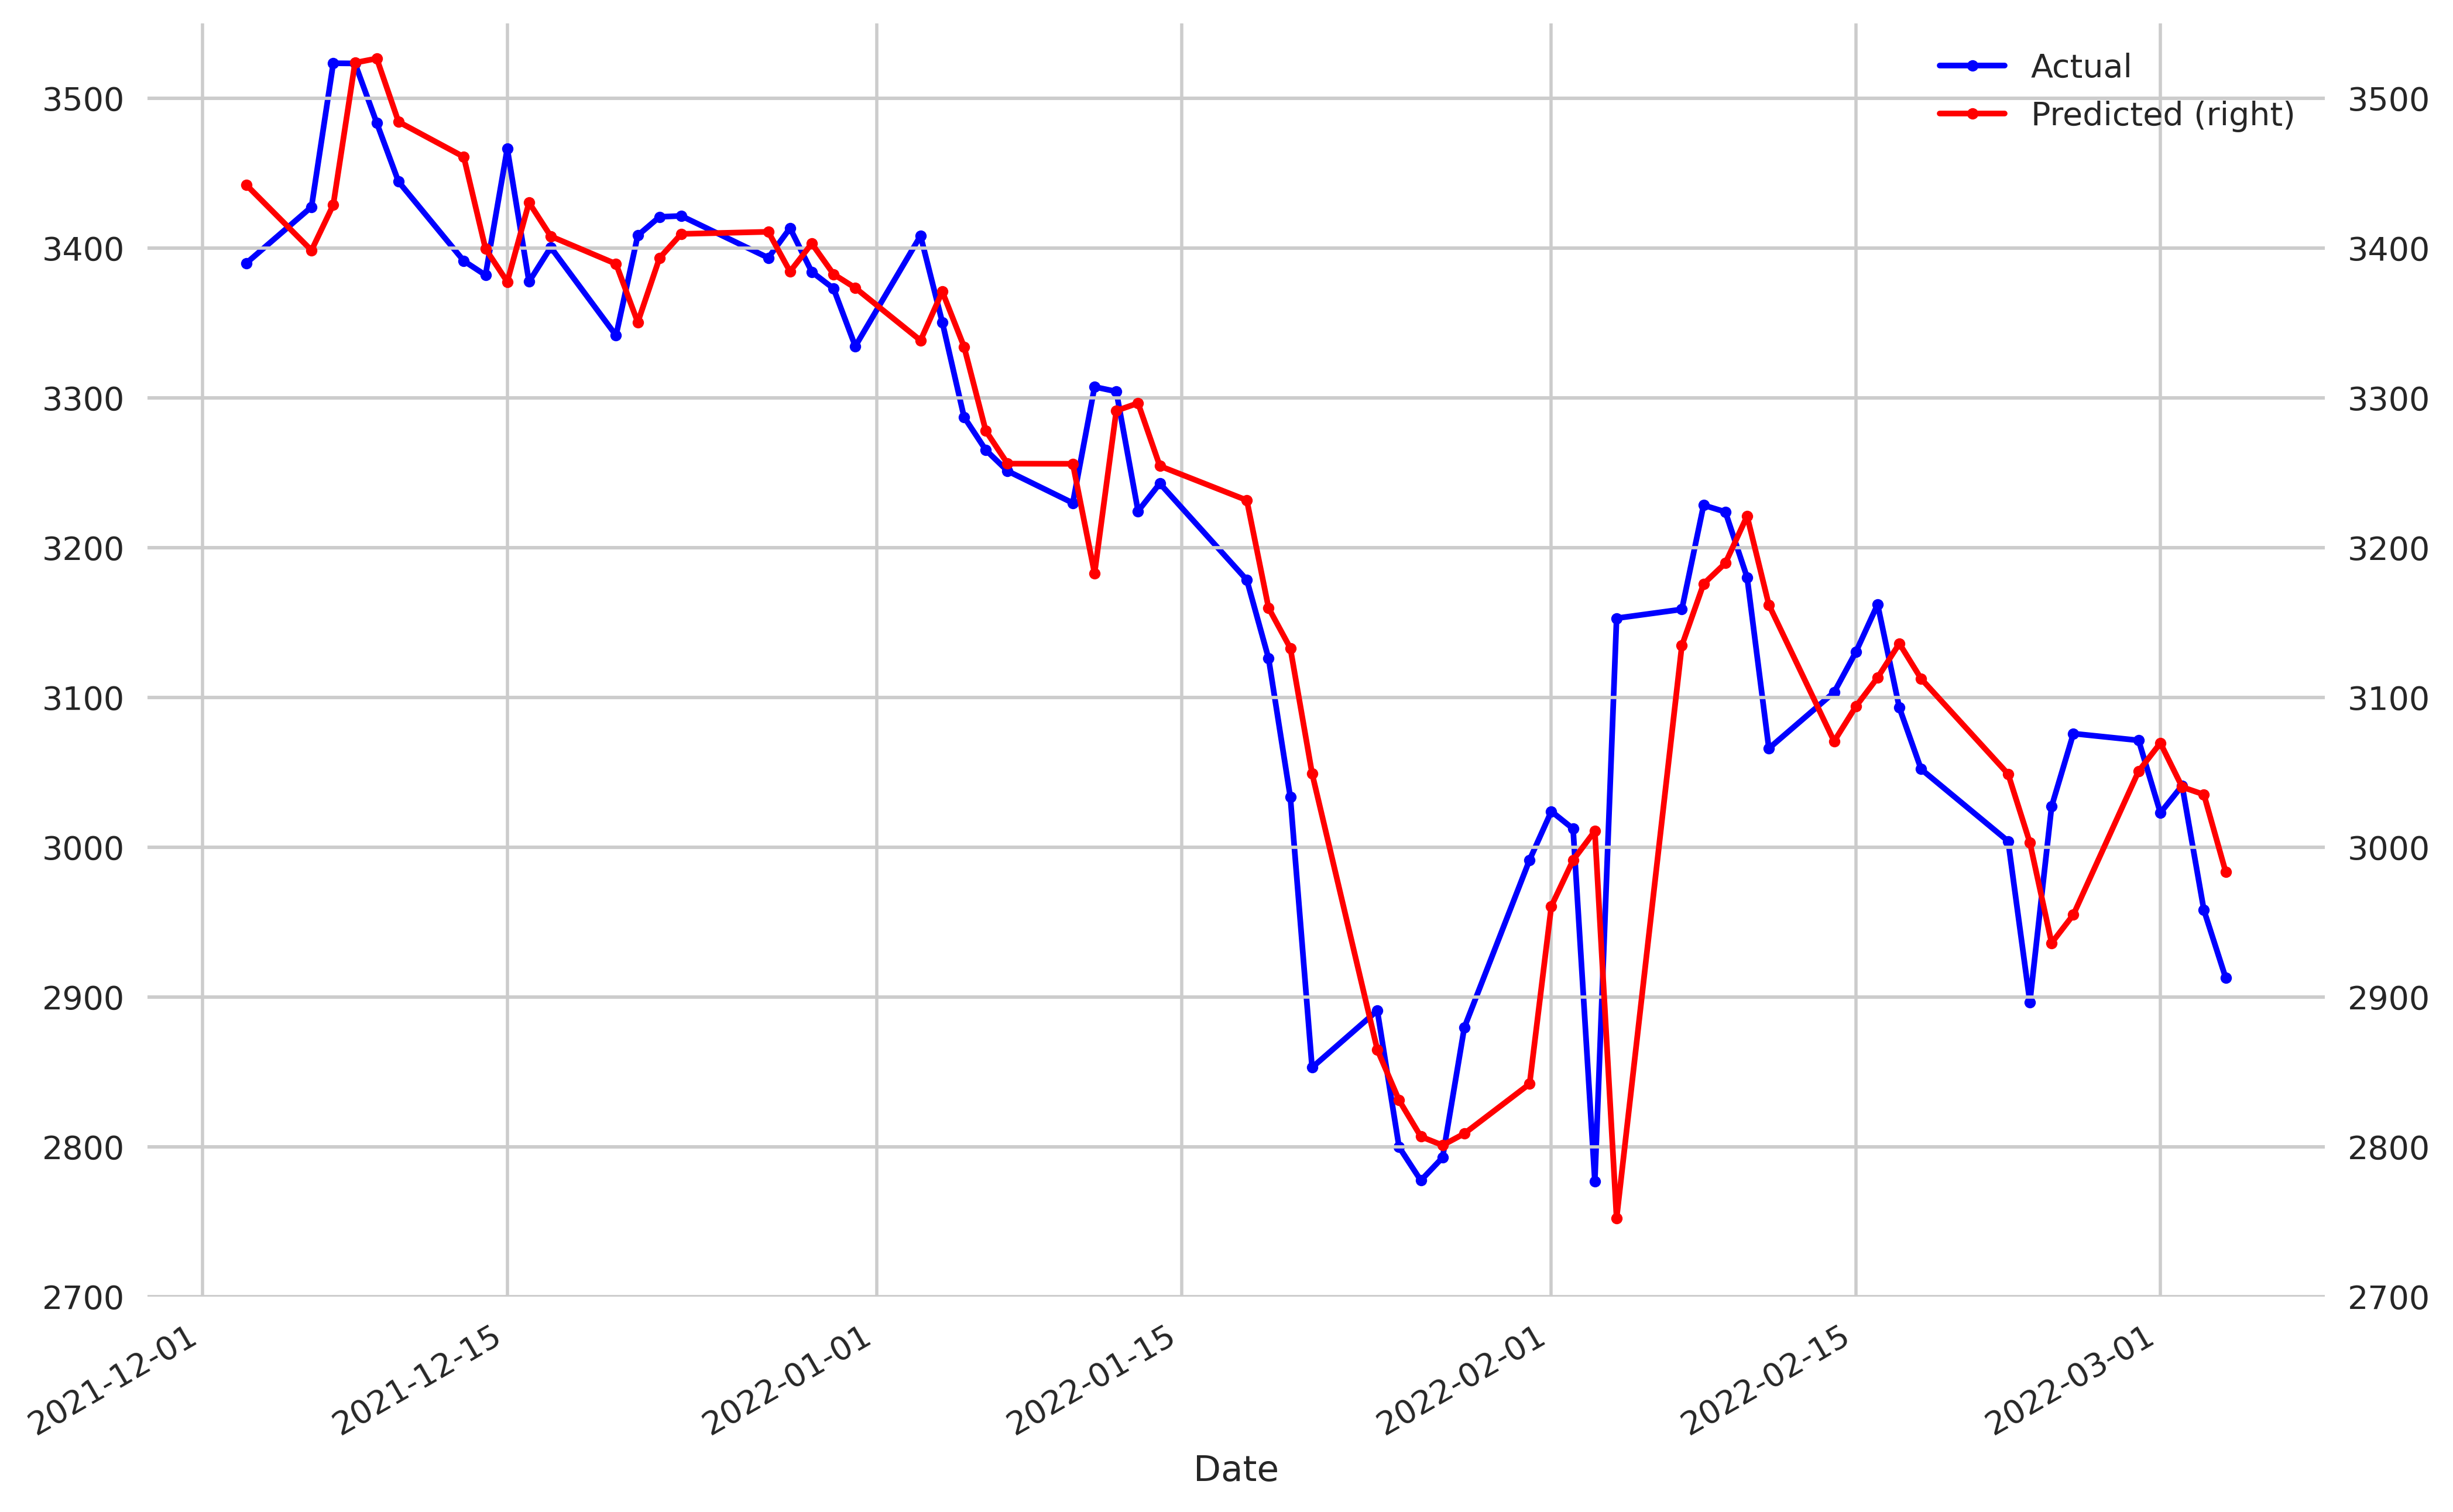

In [141]:
plt.figure(figsize=(12,8))

ax1 = df_compare["5. adjusted close"][-63:].plot(color='blue', grid=True, secondary_y=False, label='Actual', marker='.')
ax2 = df_compare["preds"][-63:].plot(color='red', grid=True, secondary_y=True, label='Predicted', marker='.')


if ticker == "aapl":
    a, b = 155, 185
elif ticker == "amzn":
    a, b = 2700, 3550
elif ticker == "msft":
    a, b = 275, 345

ax1.set_ylim(a,b)
ax2.set_ylim(a,b)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.set_xlabel("Date")
plt.legend(h1+h2, l1+l2, loc=1)
plt.show()

In [142]:
df_compare.head()

,5. adjusted close,preds,return,increase
date,,,,
2021-03-18,3027.99,3117.081543,-0.034359,0.0
2021-03-19,3074.96,3029.163818,0.015512,1.0
2021-03-22,3110.87,3046.832275,0.011678,1.0
2021-03-23,3137.50,3094.319580,0.008560,1.0
2021-03-24,3087.07,3139.950684,-0.016073,0.0


In [143]:
df_compare.tail()

,5. adjusted close,preds,return,increase
date,,,,
2022-02-28,3071.26,3050.721191,-0.001466,0.0
2022-03-01,3022.84,3069.479492,-0.015766,0.0
2022-03-02,3041.05,3040.115479,0.006024,1.0
2022-03-03,2957.97,3035.098145,-0.027320,0.0
2022-03-04,2912.82,2983.579590,-0.015264,0.0


In [144]:
df_compare["increase"] = df_compare["increase"].shift(-1)
df_compare["return"] = df_compare["return"].shift(-1)
df_compare["preds"] = df_compare["preds"].shift(-1)

In [145]:
df_compare.head()

,5. adjusted close,preds,return,increase
date,,,,
2021-03-18,3027.99,3029.163818,0.015512,1.0
2021-03-19,3074.96,3046.832275,0.011678,1.0
2021-03-22,3110.87,3094.319580,0.008560,1.0
2021-03-23,3137.50,3139.950684,-0.016073,0.0
2021-03-24,3087.07,3103.531982,-0.013220,0.0


In [146]:
df_compare.tail()

,5. adjusted close,preds,return,increase
date,,,,
2022-02-28,3071.26,3069.479492,-0.015766,0.0
2022-03-01,3022.84,3040.115479,0.006024,1.0
2022-03-02,3041.05,3035.098145,-0.027320,0.0
2022-03-03,2957.97,2983.579590,-0.015264,0.0
2022-03-04,2912.82,NaN,NaN,NaN


In [147]:
df_compare["pred_increase"] = np.where(df_compare["preds"] > df_compare["5. adjusted close"], 1.0, 0.0)

In [148]:
df_compare

,5. adjusted close,preds,return,increase,pred_increase
date,,,,,
2021-03-18,3027.99,3029.163818,0.015512,1.0,1.0
2021-03-19,3074.96,3046.832275,0.011678,1.0,0.0
2021-03-22,3110.87,3094.319580,0.008560,1.0,0.0
2021-03-23,3137.50,3139.950684,-0.016073,0.0,1.0
2021-03-24,3087.07,3103.531982,-0.013220,0.0,1.0
...,...,...,...,...,...
2022-02-28,3071.26,3069.479492,-0.015766,0.0,0.0
2022-03-01,3022.84,3040.115479,0.006024,1.0,1.0
2022-03-02,3041.05,3035.098145,-0.027320,0.0,0.0


In [149]:
df_compare = df_compare.drop("2022-03-04")


### Postive Increase Prediction %

In [150]:
df_compare[(df_compare["increase"]==1) & (df_compare["pred_increase"]==1)].shape[0] / df_compare[(df_compare["increase"]==1)].shape[0]

0.5041322314049587

### Negative Increase Prediction %

In [151]:
df_compare[(df_compare["increase"]==0) & (df_compare["pred_increase"]==0)].shape[0] / df_compare[(df_compare["increase"]==0)].shape[0]

0.5245901639344263

### Overall Prediction Accuracy %

In [152]:
df_compare[(df_compare["increase"] == df_compare["pred_increase"])].shape[0] / (df_compare.shape[0])

0.51440329218107

### Actual Distribution of Increase (1) vs. Decrease (0)

In [153]:
df_compare["increase"].value_counts()

0.0    122
1.0    121
Name: increase, dtype: int64

In [154]:
df_compare["increase"].value_counts(normalize=True)

0.0    0.502058
1.0    0.497942
Name: increase, dtype: float64

### Predicted Distribution of Increase (1) vs. Decrease (0)

In [155]:
df_compare["pred_increase"].value_counts()

0.0    124
1.0    119
Name: pred_increase, dtype: int64

In [156]:
df_compare["pred_increase"].value_counts(normalize=True)

0.0    0.510288
1.0    0.489712
Name: pred_increase, dtype: float64

In [157]:
from sklearn.metrics import confusion_matrix, classification_report

In [165]:
class_names = ["Down", "Up"]

In [159]:
print(classification_report(df_compare["increase"], df_compare["pred_increase"], target_names=class_names, digits=4))

              precision    recall  f1-score   support

        Down     0.5161    0.5246    0.5203       122
          Up     0.5126    0.5041    0.5083       121

    accuracy                         0.5144       243
   macro avg     0.5144    0.5144    0.5143       243
weighted avg     0.5144    0.5144    0.5144       243



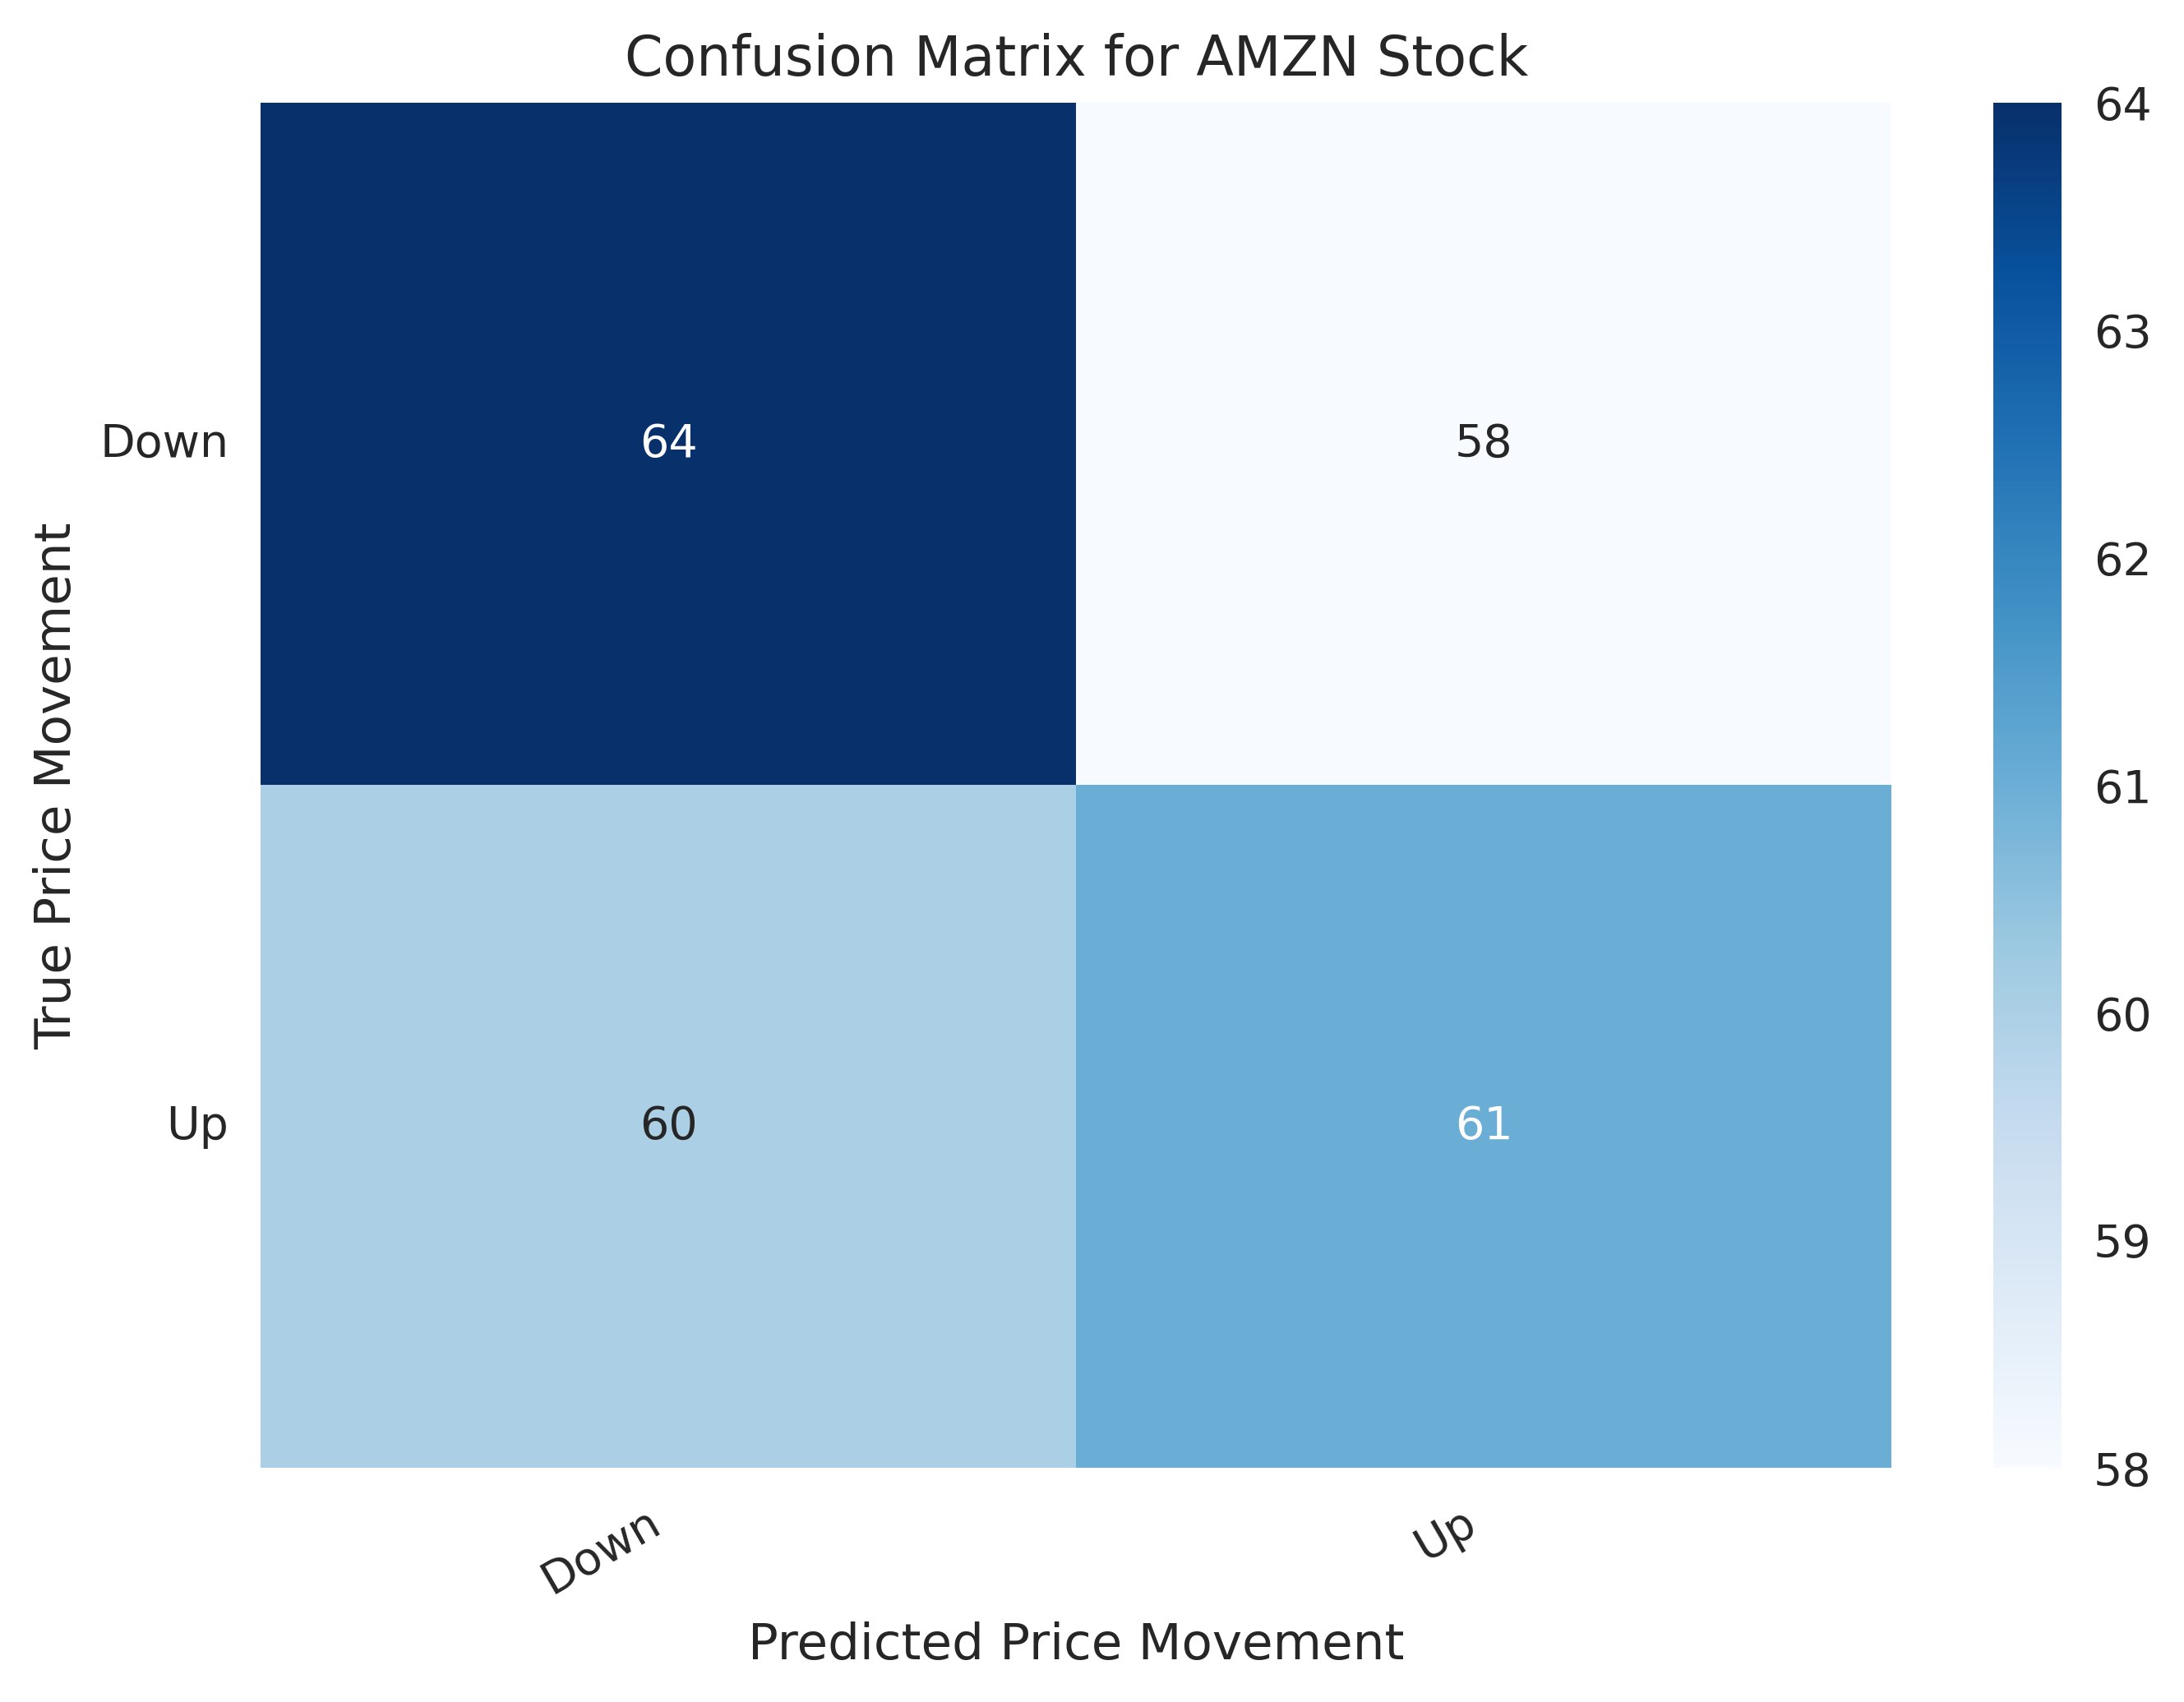

In [166]:
def plot_confusion_matrix(confusion_matrix):
  hm = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(), rotation=0, ha='right')
  hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.title(f'Confusion Matrix for {ticker_upper} Stock')
  plt.ylabel('True Price Movement')
  plt.xlabel('Predicted Price Movement');


cm = confusion_matrix(df_compare["increase"], df_compare["pred_increase"])
df_ = pd.DataFrame(cm, index=class_names, columns=class_names)
plot_confusion_matrix(df_)